In [3]:
# === Instalar dependência para remover acentos ===
!pip install -q unidecode

# === Gurobi ===
!pip install gurobipy

In [4]:
# === Imports e autenticação ===
import unidecode
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
import re

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# === Função para ler dados do Google Sheets ===
def get_google_sheet_data(sheet_url, aba_nome):
    planilha = gc.open_by_url(sheet_url)
    aba = planilha.worksheet(aba_nome)
    dados = aba.get_all_values()
    df = pd.DataFrame(dados[1:], columns=dados[0])
    return df

# === URLs e abas ===
url_disciplinas = 'https://docs.google.com/spreadsheets/d/1wqxz3XVefI_VXWuNF4xN2MQOz4f7PQwrEyDbJCLO6bE'
url_respostas   = 'https://docs.google.com/spreadsheets/d/1W10VIGJg-w4kcDzojCpQQC4FNSMWK9-IZEhM8pRZG30/edit?usp=sharing'

aba_disciplinas = 'Cópia de 2025-1 (caso 0)'
aba_respostas   = 'Respostas dos Formulários 1'

# === Leitura das planilhas ===
df_disciplinas = get_google_sheet_data(url_disciplinas, aba_disciplinas)
df_respostas   = get_google_sheet_data(url_respostas, aba_respostas)

# === Transformação da planilha de disciplinas ===
disciplinas_long = df_disciplinas.melt(
    id_vars=['Período', 'Disciplinas Ofertadas na COENC', 'CH'],
    var_name='Nome',
    value_name='CH_Prof'
)

# === Remove linhas onde não há carga horária atribuída ===
disciplinas_long = disciplinas_long[disciplinas_long['CH_Prof'].str.strip() != '']
disciplinas_long['Nome'] = disciplinas_long['Nome'].str.strip().str.lower()

# === Normalização dos nomes das respostas ===
def extrair_primeiro_nome(nome_completo):
    if isinstance(nome_completo, str):
        primeiro = nome_completo.strip().split()[0]
        return unidecode.unidecode(primeiro.lower())
    return ''

df_respostas['Nome'] = df_respostas['Nome Completo'].apply(extrair_primeiro_nome)

# === Merge das planilhas ===
df_completo = pd.merge(disciplinas_long, df_respostas, on='Nome', how='left')

# === Remove linhas com 'Disciplinas Ofertadas na COENC' e 'Período' vazias ou em branco ===
df_completo = df_completo[df_completo['Disciplinas Ofertadas na COENC'].notna() & (df_completo['Disciplinas Ofertadas na COENC'].str.strip() != '')]
df_completo = df_completo[df_completo['Período'].notna() & (df_completo['Período'].str.strip() != '')]

# === Remove a coluna 'Carimbo de data/hora' e email ===
df_completo = df_completo.drop(columns=['Carimbo de data/hora', 'Endereço de e-mail'])


# === Preferências por horário ===
dias_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
colunas_preferencia = [f'Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de {dia}' for dia in dias_semana]
colunas_rejeicao = [f'Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na {dia}' for dia in dias_semana]
colunas_rejeicao_alt = [f'Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades presenciais no campus relacionadas a aulas na {dia}' for dia in dias_semana]

# === Declaração dos turnos  [ignorando inicialmente o período noturno] ===
turnos = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6',
          'T1', 'T2', 'T3', 'T4', 'T5', 'T6']

linhas = []

# Percorre cada linha (resposta) do DataFrame df_respostas
for i, row in df_respostas.iterrows():
    nome = row['Nome'].strip()    # Obtém o nome do professor e remove espaços extras

    # Percorre os dias da semana com índice
    for i_dia, dia in enumerate(dias_semana):
        # Pega os nomes das colunas correspondentes a preferências e rejeições para o dia atual
        col_pref = colunas_preferencia[i_dia]
        col_rej1 = colunas_rejeicao[i_dia]
        col_rej2 = colunas_rejeicao_alt[i_dia]
        # Inicializa os horários do dia como 0 (neutro) para todos os turnos Manhã e Tarde
        horarios_dia = {t: 0 for t in turnos}

        # Horários preferidos (+1) — só Manhã e Tarde
        if pd.notna(row.get(col_pref)):
            horarios_pref = re.findall(r'[MT]\d', row[col_pref])
            for h in horarios_pref:
                horarios_dia[h] = 1 # Marca como preferência

        # Horários rejeitados (-1) se ainda não tiver +1 — só Manhã e Tarde
        for col_rej in [col_rej1, col_rej2]:
            if col_rej in row and pd.notna(row[col_rej]):
                horarios_rej = re.findall(r'[MT]\d', row[col_rej])
                for h in horarios_rej:
                    if horarios_dia[h] == 0: # Só marca como rejeição se ainda não for preferência
                        horarios_dia[h] = -1

        # Para cada turno registra a preferência como uma nova linha
        for turno, valor in horarios_dia.items():
            linhas.append({
                'nome': nome,
                'dia': dia,
                'horario': turno,
                'preferencia': valor
            })

# Cria um DataFrame a partir das linhas formatadas com as preferências
preferencias_formatadas = pd.DataFrame(linhas)

# === Adicionar horários padrão para professores que não responderam ===
df_ch = disciplinas_long.pivot_table(index='Nome', columns='Período', values='CH_Prof', aggfunc='first').fillna(0) # Cria uma tabela dinâmica (pivot) com a carga horária por professor e período
df_ch = df_ch.applymap(lambda x: int(x) if str(x).isdigit() else 0) # Converte os valores para inteiros, tratando casos onde o valor não é número

professores_com_ch = df_ch[df_ch.sum(axis=1) > 0].index # Lista de professores que possuem carga horária (>0)
professores_com_pref = preferencias_formatadas['nome'].unique() # Lista de professores que responderam o formulário de preferência
faltando = [p for p in professores_com_ch if p not in professores_com_pref] # Identifica os professores que têm carga horária mas não responderam o formulário

# Define os horários padrão
horarios_default = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
linhas_default = []

# Para cada professor faltante, adiciona todos os horários padrão para todos os dias da semana
for nome in faltando:
    for dia in dias_semana:
        for h in horarios_default:
            linhas_default.append({
                'nome': nome,
                'dia': dia,
                'horario': h,
                'preferencia': 0
            })

# Concatena as preferências padrão com o DataFrame original de preferências
preferencias_formatadas = pd.concat([
    preferencias_formatadas,
    pd.DataFrame(linhas_default)
], ignore_index=True)

print(f"✅ Horários padrão adicionados para {len(faltando)} professores que não responderam o formulário.")

# === Preferência por aulas condensadas ou espalhadas ===
def interpretar_condensadas(valor):
    if isinstance(valor, str):
        valor = valor.strip().lower()
        if 'condensada' in valor:
            return -1 # Preferência por aulas condensadas
        elif 'espalhada' in valor:
            return 1  # Preferência por aulas espalhadas
    return 0          # Neutro ou não especificado

df_respostas['pref_p'] = df_respostas['Prefere que as Aulas sejam'].apply(interpretar_condensadas)

# === Exibir saídas ===
print("✅ DataFrame completo (disciplinas + respostas):")
display(df_completo.head())

print("\n✅ Preferências por professor, dia e horário:")
display(preferencias_formatadas.head())

print("\n✅ Parâmetro de preferência por aulas condensadas ou espalhadas:")
display(df_respostas[['Nome', 'pref_p']].head())



✅ Horários padrão adicionados para 4 professores que não responderam o formulário.
✅ DataFrame completo (disciplinas + respostas):


<ipython-input-4-c65c42498547>:116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ch = df_ch.applymap(lambda x: int(x) if str(x).isdigit() else 0) # Converte os valores para inteiros, tratando casos onde o valor não é número


,Período,Disciplinas Ofertadas na COENC,CH,Nome,CH_Prof,Nome Completo,"No próximo semestre, gostaria de:","Gostaria de ministrar aulas em outros cursos, além da Engenharia de Computação?",Quais os dias que gostaria de realizar a MANUTENÇÃO de ensino (Máximo dois dias),Quantas matérias está ministrando Atualmente?,...,"Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Segunda","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Terça","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Quarta","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Quinta","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Sexta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades presenciais no campus relacionadas a aulas na Segunda","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Terça","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Quarta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Quinta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Sexta"
0,1,Materiais e Equipamentos Elétricos,4,adalberto,4,Adalberto Zanatta Neder Lazarini,Manter as matérias e ministrar outras,Não,Segunda,3,...,"M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","T1 (13h - 13h50), T2 (13h50 - 14h40), T3 (14h...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10) ., 2 T4...","3 M1 (7h30 - 8h20), 3 M2 (8h20 - 9h10), 3 T4 (...","4 M1 (7h30 - 8h20), 4 M2 (8h20 - 9h10), 4 T4 (...","5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10), 5 T4 (...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10), 6 T4 (..."
1,7,Controle Digital,4,adalberto,4,Adalberto Zanatta Neder Lazarini,Manter as matérias e ministrar outras,Não,Segunda,3,...,"M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","T1 (13h - 13h50), T2 (13h50 - 14h40), T3 (14h...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10) ., 2 T4...","3 M1 (7h30 - 8h20), 3 M2 (8h20 - 9h10), 3 T4 (...","4 M1 (7h30 - 8h20), 4 M2 (8h20 - 9h10), 4 T4 (...","5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10), 5 T4 (...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10), 6 T4 (..."
4,3,Arquitetura e Organização de Computadores,6,andre,6,André,Manter apenas as disciplinas que ministro aulas,Não,"Terça, Sexta",3,...,"M1 (7h30 - 8h20), M2 (8h20 - 9h10)",,"M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M4 (10h20 - 11h10), M5 (11h10 - 12h)",,"2 T1 (13h - 13h50), 2 T2 (13h50 - 14h40), 2 T3...","3 M1 (7h30 - 8h20), 3 M2 (8h20 - 9h10), 3 M3 (...","4 T1 (13h - 13h50), 4 T2 (13h50 - 14h40), 4 T3...","5 T1 (13h - 13h50), 5 T2 (13h50 - 14h40), 5 T3...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10), 6 M3 (..."
5,5,Sistemas Operacionais,4,andre,4,André,Manter apenas as disciplinas que ministro aulas,Não,"Terça, Sexta",3,...,"M1 (7h30 - 8h20), M2 (8h20 - 9h10)",,"M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M4 (10h20 - 11h10), M5 (11h10 - 12h)",,"2 T1 (13h - 13h50), 2 T2 (13h50 - 14h40), 2 T3...","3 M1 (7h30 - 8h20), 3 M2 (8h20 - 9h10), 3 M3 (...","4 T1 (13h - 13h50), 4 T2 (13h50 - 14h40), 4 T3...","5 T1 (13h - 13h50), 5 T2 (13h50 - 14h40), 5 T3...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10), 6 M3 (..."
8,6,Processamento Digital de Sinais,4,daniel,4,Daniel Prado de Campos,Manter apenas as disciplinas que ministro aulas,Não,"Quinta, Sexta",3,...,"M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","


✅ Preferências por professor, dia e horário:


,nome,dia,horario,preferencia
0,tamara,Segunda,M1,-1
1,tamara,Segunda,M2,-1
2,tamara,Segunda,M3,-1
3,tamara,Segunda,M4,-1
4,tamara,Segunda,M5,-1



✅ Parâmetro de preferência por aulas condensadas ou espalhadas:


,Nome,pref_p
0,tamara,-1
1,rafael,1
2,luiz,-1
3,marcelo,-1
4,daniel,-1


In [5]:
# === Exibir saída completa ===

print("✅ DataFrame completo (disciplinas + respostas):")
display(df_completo)

✅ DataFrame completo (disciplinas + respostas):


,Período,Disciplinas Ofertadas na COENC,CH,Nome,CH_Prof,Nome Completo,"No próximo semestre, gostaria de:","Gostaria de ministrar aulas em outros cursos, além da Engenharia de Computação?",Quais os dias que gostaria de realizar a MANUTENÇÃO de ensino (Máximo dois dias),Quantas matérias está ministrando Atualmente?,...,"Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Segunda","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Terça","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Quarta","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Quinta","Conforme o Quadro de Horários, informe os horários de Preferência para MINISTRAR as aulas de Sexta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades presenciais no campus relacionadas a aulas na Segunda","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Terça","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Quarta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Quinta","Conforme o Quadro de Horários, informe os horários que NÃO gostaria de realizar atividades relacionadas a aulas na Sexta"
0,1,Materiais e Equipamentos Elétricos,4,adalberto,4,Adalberto Zanatta Neder Lazarini,Manter as matérias e ministrar outras,Não,Segunda,3,...,"M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","T1 (13h - 13h50), T2 (13h50 - 14h40), T3 (14h...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10) ., 2 T4...","3 M1 (7h30 - 8h20), 3 M2 (8h20 - 9h10), 3 T4 (...","4 M1 (7h30 - 8h20), 4 M2 (8h20 - 9h10), 4 T4 (...","5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10), 5 T4 (...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10), 6 T4 (..."
1,7,Controle Digital,4,adalberto,4,Adalberto Zanatta Neder Lazarini,Manter as matérias e ministrar outras,Não,Segunda,3,...,"M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","T1 (13h - 13h50), T2 (13h50 - 14h40), T3 (14h...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","M3 (9h10 - 10h), M4 (10h20 - 11h10), M5 (11h10...","2 M1 (7h30 - 8h20), 2 M2 (8h20 - 9h10) ., 2 T4...","3 M1 (7h30 - 8h20), 3 M2 (8h20 - 9h10), 3 T4 (...","4 M1 (7h30 - 8h20), 4 M2 (8h20 - 9h10), 4 T4 (...","5 M1 (7h30 - 8h20), 5 M2 (8h20 - 9h10), 5 T4 (...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10), 6 T4 (..."
4,3,Arquitetura e Organização de Computadores,6,andre,6,André,Manter apenas as disciplinas que ministro aulas,Não,"Terça, Sexta",3,...,"M1 (7h30 - 8h20), M2 (8h20 - 9h10)",,"M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M4 (10h20 - 11h10), M5 (11h10 - 12h)",,"2 T1 (13h - 13h50), 2 T2 (13h50 - 14h40), 2 T3...","3 M1 (7h30 - 8h20), 3 M2 (8h20 - 9h10), 3 M3 (...","4 T1 (13h - 13h50), 4 T2 (13h50 - 14h40), 4 T3...","5 T1 (13h - 13h50), 5 T2 (13h50 - 14h40), 5 T3...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10), 6 M3 (..."
5,5,Sistemas Operacionais,4,andre,4,André,Manter apenas as disciplinas que ministro aulas,Não,"Terça, Sexta",3,...,"M1 (7h30 - 8h20), M2 (8h20 - 9h10)",,"M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","M4 (10h20 - 11h10), M5 (11h10 - 12h)",,"2 T1 (13h - 13h50), 2 T2 (13h50 - 14h40), 2 T3...","3 M1 (7h30 - 8h20), 3 M2 (8h20 - 9h10), 3 M3 (...","4 T1 (13h - 13h50), 4 T2 (13h50 - 14h40), 4 T3...","5 T1 (13h - 13h50), 5 T2 (13h50 - 14h40), 5 T3...","6 M1 (7h30 - 8h20), 6 M2 (8h20 - 9h10), 6 M3 (..."
8,6,Processamento Digital de Sinais,4,daniel,4,Daniel Prado de Campos,Manter apenas as disciplinas que ministro aulas,Não,"Quinta, Sexta",3,...,"M1 (7h30 - 8h20), M2 (8h20 - 9h10), M3 (9h10 -...","

In [6]:
# === Pivot direto das preferências ===
estrutura_otimizador = preferencias_formatadas.pivot_table(
    index=['nome', 'dia'],
    columns='horario',
    values='preferencia',
    fill_value=0
).reset_index()

# === Exibir resultado ===
estrutura_otimizador

horario,nome,dia,M1,M2,M3,M4,M5,M6,T1,T2,T3,T4,T5,T6
0,adalberto,Quarta,-1.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,-1.0,-1.0,-1.0
1,adalberto,Quinta,-1.0,-1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.0,-1.0
2,adalberto,Segunda,-1.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,-1.0,-1.0
3,adalberto,Sexta,-1.0,-1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.0,-1.0
4,adalberto,Terça,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,wendel,Quarta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,wendel,Quinta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,wendel,Segunda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,wendel,Sexta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# === Estrutura otimizada para entrada do otimizador ===

# === Professores ===
professores_lista = sorted(estrutura_otimizador['nome'].unique())
professor_idx = {nome: idx for idx, nome in enumerate(professores_lista)}
P = len(professores_lista)

# == Email com base no Professor ==
emails_professores = []
for nome_prof_na_lista_final in professores_lista:
    # Procurar o professor no DataFrame de respostas original
    registro_do_professor_em_respostas = df_respostas[df_respostas['Nome'] == nome_prof_na_lista_final].head(1)

    email_professor = None # Começa como None
    # Verifica se encontrou ao menos uma linha correspondente no formulário
    if not registro_do_professor_em_respostas.empty:
        email_bruto = registro_do_professor_em_respostas['Endereço de e-mail'].iloc[0] # Extrai o valor da coluna de e-mail
        # Verifica se o campo de e-mail não está vazio nem é NaN
        if pd.notna(email_bruto) and str(email_bruto).strip() != "":
            email_professor = str(email_bruto).strip() # Remove espaços e converte para string

    emails_professores.append(email_professor)

# === Dias ===
dia_idx = {dia: idx for idx, dia in enumerate(dias_semana)}
D = len(dia_idx)

# === Horários ===
horario_idx = {hor: idx for idx, hor in enumerate(turnos)}
H = len(horario_idx)

# === Disciplinas ===
disciplinas_lista = sorted(df_completo['Disciplinas Ofertadas na COENC'].unique())
disciplina_idx = {disc: idx for idx, disc in enumerate(disciplinas_lista)}
T = len(disciplinas_lista)


# === Arrumar o Período com a Disciplina ===
periodo_disciplina = {}
for _, row in df_completo.iterrows():
    if pd.notna(row['Período']) and row['Disciplinas Ofertadas na COENC'] not in periodo_disciplina:
        periodo_disciplina[row['Disciplinas Ofertadas na COENC']] = int(row['Período'])

# == Arruma o índice da disciplina para o período real ==
periodo_real = {}
for nome, idx in disciplina_idx.items():
    periodo_real[idx] = periodo_disciplina.get(nome, -1)

# === Conjuntos ===
professores = range(P)
periodos = range(T)
dias = range(D)
horarios = range(H)

# === Inicializa PV e Disp ===
PV = {}
Disp = [[[1 for _ in horario_idx] for _ in dia_idx] for _ in professor_idx]

for _, row in estrutura_otimizador.iterrows():
    p = professor_idx[row['nome']]
    d = dia_idx[row['dia']]
    for horario in turnos:
        h = horario_idx[horario]
        valor = row[horario]
        PV[(p, d, h)] = valor
        if valor == -1:
            Disp[p][d][h] = 0

# === Criar diretamente CH e pref_p ===
CH = [[0 for _ in disciplina_idx] for _ in professor_idx]
pref_p = {professor_idx[row['Nome']]: row['pref_p'] for _, row in df_respostas.iterrows() if row['Nome'] in professor_idx}

for _, row in df_completo.iterrows():
    nome = row['Nome']
    if nome in professor_idx and row['Disciplinas Ofertadas na COENC'] in disciplina_idx:
        p = professor_idx[nome]
        t = disciplina_idx[row['Disciplinas Ofertadas na COENC']]
        ch_prof = row['CH_Prof']
        if str(ch_prof).replace(',', '').isdigit():
            CH[p][t] = int(float(ch_prof.replace(',', '.')))

# === Exibir verificação rápida ===
print("✅ Estruturas finais geradas com sucesso!")
print("Professores (índices):", professor_idx)
print("Disciplinas (índices):", disciplina_idx)

# === Exemplo de verificação de PV e DISP de TODOS os professores ===
print("\n✅ Preferências e Disponibilidades por Professor:")
for nome_prof, idx_prof in professor_idx.items():
    print(f"\n\n👤 Professor: {nome_prof.title()}")
    for dia_nome, idx_dia in dia_idx.items():
        preferencias_dia = []
        disponibilidade_dia = []
        for turno_nome, idx_turno in horario_idx.items():
            valor_pref = PV.get((idx_prof, idx_dia, idx_turno))
            valor_disp = Disp[idx_prof][idx_dia][idx_turno]

            if valor_pref == 1:
                preferencias_dia.append(turno_nome)
            if valor_disp == 0:
                disponibilidade_dia.append(turno_nome)

        print(f"  📅 {dia_nome}:")
        print(f"    ✔️ Preferências: {preferencias_dia if preferencias_dia else 'Nenhuma'}")
        print(f"    ❌ Indisponível: {disponibilidade_dia if disponibilidade_dia else 'Nenhuma'}")


✅ Estruturas finais geradas com sucesso!
Professores (índices): {'adalberto': 0, 'andre': 1, 'daniel': 2, 'fabio': 3, 'fernando': 4, 'lucio': 5, 'luiz': 6, 'marcelo': 7, 'mauricio': 8, 'muriel': 9, 'rafael': 10, 'tamara': 11, 'wagner': 12, 'wendel': 13}
Disciplinas (índices): {'Arquitetura e Organização de Computadores': 0, 'Banco de Dados': 1, 'Compiladores': 2, 'Comunicação de Dados': 3, 'Controle Digital': 4, 'Desenho Técnico': 5, 'Desenvolvimento de Aplicações Web': 6, 'Engenharia de Software': 7, 'Estrutura de Dados 1': 8, 'Estrutura de Dados 2': 9, 'Fundamentos de Controle': 10, 'Fundamentos de Programação 1': 11, 'Fundamentos de Programação 2': 12, 'Instrumentação Eletrônica': 13, 'Introdução à Engenharia de Computação': 14, 'Introdução à Lógica para Computação': 15, 'Lógica Reconfigurável': 16, 'Materiais e Equipamentos Elétricos': 17, 'Oficina de Integração 1': 18, 'Oficina de Integração 2': 19, 'Optativa 1': 20, 'Optativa 2': 21, 'Optativa 3': 22, 'Processamento Digital de Si

In [8]:
import gurobipy as gp
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
from oauth2client.client import GoogleCredentials

In [9]:
'''
!pip install gurobipy>=10

model_size_limited = gp.Model()
'''
from gurobipy import Env

In [10]:
# Create an environment with your WLS license
param = {
  "WLSACCESSID": 'e9019a7c-1658-49e2-89a5-f8d0ebf9d803',
  "WLSSECRET": 'a5c88295-6dd6-406e-8b53-5294263ae92b',
  "LICENSEID": 2541920
  }
env = gp.Env(params=param)

# Create the model within the Gurobi environment
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2541920
Academic license 2541920 - for non-commercial use only - registered to an___@alunos.utfpr.edu.br


In [11]:
# === Definir limite de tempo ===
model.setParam("TimeLimit", 40)

Set parameter TimeLimit to value 40


In [12]:
# === Variáveis de decisão ===
x = model.addVars(professores, periodos, dias, horarios, vtype=gp.GRB.BINARY)
b = model.addVars(professores, periodos, dias,  vtype=gp.GRB.BINARY)
e = model.addVars(professores, periodos, dias, vtype=gp.GRB.CONTINUOUS, lb=0)
f = model.addVars(professores, periodos, dias, vtype=gp.GRB.CONTINUOUS, lb=0)
a = model.addVars(professores, dias,  vtype=gp.GRB.BINARY)

In [13]:
# === Inicializa "Hist" como 0 para cada professor ===
Hist = {(p, t): 0 for p in professores for t in periodos}

# === Remover valores inválidos de Hist ===
for k in list(Hist.keys()):
    if pd.isna(Hist[k]) or Hist[k] is None:
        Hist[k] = 0


# === Garantir que todos os valores de pref_p são numéricos e não nulos ===
for k in list(pref_p.keys()):
    if pd.isna(pref_p[k]) or pref_p[k] is None:
        pref_p[k] = 0

# === Garantir que todos os valores de PV são numéricos e não nulos ===
for k in list(PV.keys()):
    if pd.isna(PV[k]) or PV[k] is None:
        PV[k] = 0



In [14]:
# === Verificação de consistência nas chaves utilizadas ===
erros = 0
for p in professores:
    for t in periodos:
        for d in dias:
            for h in horarios:
                try:
                    _ = x[p, t, d, h]                     # variável de decisão existe
                    _ = PV.get((p, d, h), 0)              # preferência horário
                    _ = Hist.get((p, t), 0)               # histórico
                except Exception as e:
                    print(f"Erro em p={p}, t={t}, d={d}, h={h} → {e}")
                    erros += 1


# === Teste para verificar se todas as chaves acessadas existem ===
print(f"Total de inconsistências detectadas: {erros}")


Total de inconsistências detectadas: 0


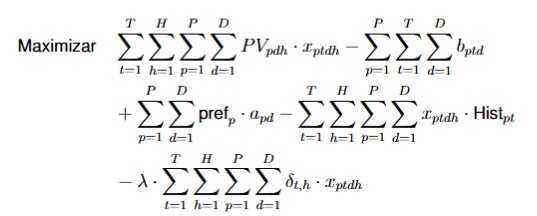

In [15]:
# == Função Objetivo de Maximizar ==
model.setObjective(
    gp.quicksum(PV.get((p, d, h), 0) * x[p, t, d, h] for p in professores for t in periodos for d in dias for h in horarios)  # Maximiza preferências dos professores
  - gp.quicksum(b[p, t, d] for p in professores for t in periodos for d in dias)                                              # Penaliza blocos de aula desconexos
  + gp.quicksum(pref_p.get(p, 0) * a[p, d] for p in professores for d in dias)                                                # Valoriza a preferência do professor por aulas condensadas ou espalhadas
  - gp.quicksum(Hist.get((p, t), 0) * x[p, t, d, h] for p in professores for t in periodos for d in dias for h in horarios)   # Penaliza com base no histórico priorizando quem teve poucas preferências atendidas anteriormente
  - gp.quicksum(                                                                                                              # Penalidade para períodos ímpares à tarde e pares pela manhã
      (10  if (periodo_real[t] % 2 == 1 and h >= 6) else 0) * x[p, t, d, h] + # penaliza ímpar à tarde
      (10  if (periodo_real[t] % 2 == 0 and h < 6) else 0) * x[p, t, d, h]    # penaliza par pela manhã
      for p in professores for t in periodos for d in dias for h in horarios ),

  sense=gp.GRB.MAXIMIZE # Objetivo: maximizar a função
)


# == Restrição: Cada período não pode ter aulas misturadas entre manhã e tarde no mesmo dia ==
for periodo in set(periodo_real.values()):
    if periodo != 10 and periodo != 11:
        disciplinas_periodo = [t for t in periodos if periodo_real[t] == periodo]
        for d in dias:
            # Não pode misturar manhã e tarde
            model.addConstr(
                gp.quicksum(x[p, t, d, h] for p in professores for t in disciplinas_periodo for h in range(0,6)) *
                gp.quicksum(x[p, t, d, h] for p in professores for t in disciplinas_periodo for h in range(6,H))
                == 0 )


In [16]:
# === Restrição que garante aulas consecutivas ===
for p in professores:
    for t in periodos:
      for d in dias:
            model.addConstr(gp.quicksum(x[p, t, d, h] for h in horarios) <= 100 * b[p, t, d])


In [17]:
# === Restrição para o início e fim das aulas ===
for p in professores:
    for t in periodos:
        for d in dias:
            for h in horarios:
                model.addConstr(e[p, t, d] <= (H + 1) - ((H + 1 - h) * x[p, t, d, h]))  # Início da aula
                model.addConstr(f[p, t, d] >= h * x[p, t, d, h])  # Fim da aula

for p in professores:
    for d in dias:
        for t in periodos:
            model.addConstr((f[p, t, d] - e[p, t, d] + b[p, t, d] - gp.quicksum(x[p, t, d, h] for h in horarios)) <= 0)

In [18]:
# === Restrição para alocar as aulas corretamente quando a carga horária é maior ou igual a 4 aulas ===
for p in professores:
    for t in periodos:
      if periodo_real[t] != 10 and periodo_real[t] != 11:  # exceções
        for d in dias:
            if CH[p][t] != 4 and CH[p][t] != 6:
                # model.addConstr(f[p, t, d] - e[p, t, d] <= 3 * b[p, t, d])
                model.addConstr(gp.quicksum(x[p, t, d, h] for h in horarios) <= 3 * b[p, t, d])
            else:
                # model.addConstr(f[p, t, d] - e[p, t, d] <= 2 * b[p, t, d])
                model.addConstr(gp.quicksum(x[p, t, d, h] for h in horarios) <= 2 * b[p, t, d])


In [19]:
# === Distribuição da carga horária ===
for p in professores:
    for t in periodos:
        model.addConstr(gp.quicksum(x[p, t, d, h] for d in dias for h in horarios) == CH[p][t])



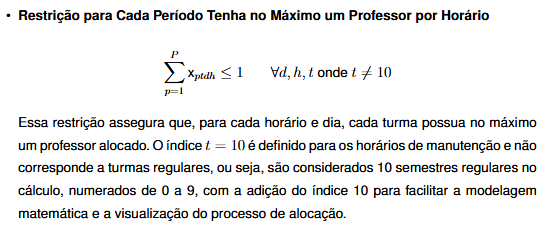

In [20]:
# === Restrição: Cada período tem que ter no dia e horário no máximo um professor alocado, exceto para turma 10 e 11 ===
for t in periodos:
    if periodo_real[t] != 10 and periodo_real[t] != 11:
        disciplinas_mesmo_periodo = [t2 for t2 in periodos if periodo_real[t2] == periodo_real[t]]
        for d in dias:
            for h in horarios:
                model.addConstr( gp.quicksum(x[p, t2, d, h] for p in professores for t2 in disciplinas_mesmo_periodo) <= 1 )


In [21]:
# === Cada professor deve ter no máximo uma aula por horário em cada dia ===
for p in professores:
    for d in dias:
        for h in horarios:
          model.addConstr(gp.quicksum(x[p, t, d, h] for t in periodos) <= 1)

In [22]:
# === Restrição de Preferência de Aula dos Professores ===
for p in professores:
     for d in dias:
         model.addConstr(gp.quicksum(b[p, t, d] for t in periodos) <= H * a[p,d])

In [23]:
# === Restrição de número máximo de aulas por dia para cada professor ===
for p in professores:
    for d in dias:
        model.addConstr(gp.quicksum(x[p, t, d, h] for t in periodos for h in horarios if periodo_real[t] != 10 and periodo_real[t] != 11) <= 7)

# === Disponibilidade de professores ===
for p in professores:
    for d in dias:
        for h in horarios:
            model.addConstr(gp.quicksum(x[p, t, d, h] for t in periodos) <= Disp[p][d][h])

# === Preferências de aulas condensadas ou espalhadas dos professores ===
for p in professores:
    for d in dias:
        model.addConstr(gp.quicksum(b[p, t, d] for t in periodos) <= H * a[p, d])  # Condensação de aulas

In [24]:
# === para CH alta (4 ou 6), bloqueio mínimo de 2h por dia ===
for p in professores:
    for t in periodos:
        if CH[p][t] in (4,6):
            for d in dias:
                # força: ou são 0h no dia, ou exatas 2h contíguas
                model.addConstr(
                    gp.quicksum(x[p, t, d, h] for h in horarios)
                    >= 2 * b[p, t, d]
                )


In [25]:
# === Verificar inconsistências entre CH e disponibilidade ===
for p in professores:
    total_disp = sum(Disp[p][d][h] for d in dias for h in horarios)
    total_ch = sum(CH[p][t] for t in periodos)

    if total_ch > total_disp:
        print(f"⚠️ Professor {p} tem CH={total_ch}, mas só {total_disp} horários disponíveis!")


In [26]:
# === 💛 Resolvendo o modelo 💛  ===
model.optimize()
status = model.status

# === Verificando o status da solução ===
if status == gp.GRB.Status.OPTIMAL or status == gp.GRB.TIME_LIMIT:
    print("Otimização bem-sucedida!")
    alocacoes = {}
    alocacoesBD = {}

    for p in range(0, P):
        for t in range(0, T):
            for d in range(0, D):
                horarios = []  # Lista para armazenar os horários alocados
                for h in range(0, H):
                    if x[p, t, d, h].X > 0.7:
                        horarios.append(h)
                # Inicializa dicionários
                if horarios:
                    if p not in alocacoes:
                        alocacoes[p] = {}
                        alocacoesBD[p] = {}
                    if d not in alocacoes[p]:
                        alocacoes[p][d] = []
                        alocacoesBD[p][d] = []
                    # Salva a disciplina t com todos os horários alocados
                    alocacoes[p][d].append((t, horarios))

                    # Salva cada horário individual para o banco de dados
                    for horario_individual in horarios:
                        alocacoesBD[p][d].append((t, horario_individual))

    # === Exibir as alocações agrupadas por professor e dia ===
    for p, dias in alocacoes.items():
        print(f"\n👩‍🏫Professor {professores_lista[p]}: 👨‍🏫")
        for d, periodos in dias.items():
            print(f"  📅 {dias_semana[d]}:")
            for t, horarios in periodos:
                periodo_lista = periodo_disciplina.get(disciplinas_lista[t], "???")
                print(f"    ⏰Período {periodo_lista} ({disciplinas_lista[t]}): Horários {', '.join([turnos[h] for h in horarios])}")

# Se o modelo não for resolvido com sucesso, exibe o código de status retornado pelo Gurobi
else:
    print(f"Otimização não foi bem-sucedida. Status: {status}")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  40

Academic license 2541920 - for non-commercial use only - registered to an___@alunos.utfpr.edu.br
Optimize a model with 68796 rows, 35770 columns and 456270 nonzeros
Model fingerprint: 0x7bc03fad
Model has 45 quadratic constraints
Variable types: 4760 continuous, 31010 integer (31010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 43841 rows and 33656 columns
Presolve time: 1.64s
Presolved: 24955 rows, 2114 columns, 62987 nonzeros
Variable types: 0 continuous, 2114 integer (1802 binary)
Performing another presolve...
Presolve removed 21039 rows and 2

In [27]:
# == Convertendo em um arquivo CSV ==

# === Definição dos turnos com horários ===
horarios_turnos = {
    'M1': ('07h30', '08h20'),
    'M2': ('08h20', '09h10'),
    'M3': ('09h10', '10h00'),
    'M4': ('10h20', '11h10'),
    'M5': ('11h10', '12h00'),
    'M6': ('12h00', '12h50'),
    'T1': ('13h00', '13h50'),
    'T2': ('13h50', '14h40'),
    'T3': ('14h40', '15h30'),
    'T4': ('15h50', '16h40'),
    'T5': ('16h40', '17h30'),
    'T6': ('17h30', '18h20'),
    'N1': ('18h40', '19h30'),
    'N2': ('19h30', '20h20'),
    'N3': ('20h20', '21h10'),
    'N4': ('21h20', '22h10'),
    'N5': ('22h10', '23h00'),
}

# === Inicializa a estrutura da tabela ===
dias_colunas = dias_semana  # ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
tabela_horario = pd.DataFrame('', index=turnos, columns=dias_colunas)

# === Preencher a tabela com as alocações ===
for p, dias in alocacoes.items():
    for d, periodos in dias.items():
        for t, horarios in periodos:
            nome_disc = disciplinas_lista[t]
            nome_prof = professores_lista[p]
            texto = f"{nome_disc} ({nome_prof.title()})"

            for h in horarios:
                turno = turnos[h]
                dia = dias_semana[d]

                # Adiciona múltiplas disciplinas por turno, separadas por nova linha
                if tabela_horario.at[turno, dia] != '':
                    tabela_horario.at[turno, dia] += '\n' + texto
                else:
                    tabela_horario.at[turno, dia] = texto

# === Adiciona colunas de horário (Início e Término)
tabela_horario.insert(0, 'Início', [horarios_turnos[t][0] for t in tabela_horario.index])
tabela_horario.insert(1, 'Término', [horarios_turnos[t][1] for t in tabela_horario.index])

# === Exporta como CSV
tabela_horario.to_csv('tabela_horarios.csv', encoding='utf-8-sig', index_label='Turno')
print("✅ Arquivo 'tabela_horarios.csv' gerado com sucesso!")


✅ Arquivo 'tabela_horarios.csv' gerado com sucesso!


# **Conectando o otimizador ao Banco de Dados**


In [28]:
# === Conectar Python ao MySQL ===
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 48.6 MB/s eta 0:00:00


In [29]:
# Conectar ao MySQL a partir do Colab e tratamento de erro
import mysql.connector
from mysql.connector import Error

def conectar_mysql():
    try:
         # Estabelece conexão com os dados fornecidos
        conn = mysql.connector.connect(
            host = "mysql-tcc.alwaysdata.net",      # Host do banco de dados (servidor)
            database = "tcc_horarios",              # Nome do banco de dados
            user = "tcc",                           # Usuário
            password = "socorrodeus",               # Senha
            port = 3306                             # Porta padrão do MySQL
        )
        # Verifica se a conexão foi estabelecida corretamente
        if conn.is_connected():
            print("Conexão ao banco de dados MySQL bem-sucedida!")
            return conn # Retorna o objeto de conexão
    # Caso ocorra algum erro na conexão, exibe a mensagem
    except Error as e:
        print(f"Erro ao conectar ao MySQL: {e}")
        return None # Retorna None se falhar



In [30]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

# Mapeia o índice dos dias do formulário para o nome usado no banco
MAP_DIA_COLAB_DB = {
    0: "Segunda", 1: "Terça", 2: "Quarta",
    3: "Quinta", 4: "Sexta", 5: "Sábado" # Mapeando de inteiros para strings
}

# Mapeia o índice do horário no Colab para o código no BD
MAP_HORARIO_IDX_CODIGO = {
    0: "M1", 1: "M2", 2: "M3", 3: "M4", 4: "M5", 5: "M6",
    6: "T1", 7: "T2", 8: "T3", 9: "T4", 10: "T5", 11: "T6",
    12: "N1", 13: "N2", 14: "N3", 15: "N4"
}

def sincronizar_professores_com_banco(conn, nomes_prof_colab_lista, emails_prof_colab_lista):
    cursor = conn.cursor()
    print(f"DEBUG: Entrando em sincronizar_professores_com_banco (v6). Total de nomes: {len(nomes_prof_colab_lista)}, Total de emails na lista original: {len(emails_prof_colab_lista)}")

    ids_prof_db = {} # Dicionário nome → id_professor

    for i, nome_prof_colab in enumerate(nomes_prof_colab_lista):
        email_para_banco = None # Assume que o professor pode não ter e-mail
        # Se houver e-mail correspondente no índice i, tenta usar
        if i < len(emails_prof_colab_lista):
            email_candidato = emails_prof_colab_lista[i]
            if not pd.isna(email_candidato):
                email_str = str(email_candidato).strip()
                if email_str and email_str.lower() != 'nan':
                    email_para_banco = email_str

        try:
            # Verifica se o professor já existe no banco
            cursor.execute("SELECT id_professor, email_institucional FROM professores WHERE nome_completo = %s", (nome_prof_colab,))
            result = cursor.fetchone()

            if result:
                # Se já existe: atualiza e-mail se necessário
                id_prof, email_db = result
                ids_prof_db[nome_prof_colab] = id_prof

                if (email_para_banco is not None and email_para_banco != email_db) or \
                   (email_para_banco is None and email_db is not None):
                    try:
                        cursor.execute("UPDATE professores SET email_institucional = %s WHERE id_professor = %s", (email_para_banco, id_prof))
                        conn.commit()
                        if email_para_banco:
                            print(f"Email do professor '{nome_prof_colab}' (ID: {id_prof}) atualizado para '{email_para_banco}'.")
                        else:
                            print(f"Email do professor '{nome_prof_colab}' (ID: {id_prof}) definido como NULL no banco.")
                    except Error as e_update:
                        print(f"Erro ao ATUALIZAR email do professor '{nome_prof_colab}': {e_update}")
                        conn.rollback()
            else:
                # Se não existe: insere novo professor
                cursor.execute("INSERT INTO professores (nome_completo, email_institucional) VALUES (%s, %s)", (nome_prof_colab, email_para_banco))
                conn.commit()
                id_prof = cursor.lastrowid
                ids_prof_db[nome_prof_colab] = id_prof
                print(f"Professor '{nome_prof_colab}' (Email: {email_para_banco if email_para_banco else 'N/A'}) inserido com ID: {id_prof}")

        except Error as e:
            print(f"Erro ao sincronizar professor '{nome_prof_colab}' (Email para DB: {email_para_banco if email_para_banco else 'N/A'}): {e}")
            conn.rollback()
            if nome_prof_colab in ids_prof_db:
                 del ids_prof_db[nome_prof_colab]

    # Exibe os resultados da sincronização
    if ids_prof_db:
        print("Professores sincronizados/encontrados no banco (após processamento completo):")
        for nome, id_p in ids_prof_db.items():
            print(f"  - {nome} (ID: {id_p})")
    else:
        print("Nenhum professor foi sincronizado ou encontrado no banco.")

    cursor.close()
    return ids_prof_db

def sincronizar_disciplinas_com_banco(conn, nomes_disc_colab_lista, periodo_real_lista, num_periodos_colab):
    cursor = conn.cursor(dictionary=True) # Usar dictionary, se for igual a True para pegar resultados como dict
    print(f"DEBUG: Entrando em sincronizar_disciplinas_com_banco (v6). Total de nomes na lista: {len(nomes_disc_colab_lista)}, num_periodos_colab (T): {num_periodos_colab}")
    map_nome_disc_para_info_db = {}

    for i in range(num_periodos_colab):
        nome_disc_colab = f"Disciplina T{i}" # Nome padrão caso não exista nome real
        carga_horaria_estimada = 4
        periodo_academico_valor = "Indefinido"

        if i < len(nomes_disc_colab_lista):
            nome_disc_colab = nomes_disc_colab_lista[i]
        else:
            print(f"AVISO: Nome real da disciplina para o índice Colab T{i} não fornecido. Usando nome genérico '{nome_disc_colab}'.")

        if i < len(periodo_real_lista):
            periodo_academico_valor = periodo_real_lista[i]
        else:
            print(f"AVISO: Período real para a disciplina '{nome_disc_colab}' (índice Colab T{i}) não fornecido. Usando '{periodo_academico_valor}'.")

        # Verifica se a disciplina já existe
        try:
            cursor.execute("SELECT id_disciplina, periodo FROM disciplinas WHERE nome_disciplina = %s", (nome_disc_colab,))
            result = cursor.fetchone()

            if result:
                id_disc = result['id_disciplina']
                periodo_db = result['periodo']
                map_nome_disc_para_info_db[nome_disc_colab] = {'id': id_disc, 'periodo': periodo_db}
            # Insere nova disciplina
            else:
                cursor.execute("INSERT INTO disciplinas (nome_disciplina, carga_horaria, periodo) VALUES (%s, %s, %s)",
                               (nome_disc_colab, carga_horaria_estimada, periodo_academico_valor))
                conn.commit()
                id_disc = cursor.lastrowid
                map_nome_disc_para_info_db[nome_disc_colab] = {'id': id_disc, 'periodo': periodo_academico_valor}
                print(f"Disciplina '{nome_disc_colab}' (Período: {periodo_academico_valor}) inserida com ID: {id_disc}")

        except Error as e:
            print(f"Erro ao sincronizar disciplina '{nome_disc_colab}': {e}")
            conn.rollback()
            if nome_disc_colab in map_nome_disc_para_info_db:
                del map_nome_disc_para_info_db[nome_disc_colab]
    # Exibe os resultados
    if map_nome_disc_para_info_db:
        print("Disciplinas sincronizadas/encontradas no banco (após processamento completo):")
        print(f"  Total de {len(map_nome_disc_para_info_db)} disciplinas mapeadas.")
    else:
        print("Nenhuma disciplina foi sincronizada ou encontrada no banco.")

    cursor.close()
    return map_nome_disc_para_info_db


def inserir_alocacoes_no_mysql(conn, alocacoes_colab,
                               num_prof_colab, prof_nomes_lista, prof_emails_lista,
                               num_periodos_colab, disc_nomes_lista, disc_periodo_lista,
                               CH_colab):
    print(f"DEBUG: Entrando em inserir_alocacoes_no_mysql (v6). conn.is_connected(): {conn.is_connected() if conn else 'N/A'}") # Log inicial da função e verificação da conexão

    # Se não houver conexão válida, interrompe
    if not conn or not conn.is_connected():
        print("Conexão com MySQL não está ativa. Abortando inserção.")
        return

    cursor = conn.cursor() # Cria cursor para comandos SQL

    # === Sincronizar professores ===
    print(f"DEBUG: Sincronizando professores... Lista de nomes: {len(prof_nomes_lista)}, Lista de emails: {len(prof_emails_lista)}")
    map_nome_prof_para_id_db = sincronizar_professores_com_banco(conn, prof_nomes_lista, prof_emails_lista)
    if not map_nome_prof_para_id_db:
        print("ERRO CRÍTICO: Nenhum professor foi sincronizado ou encontrado no banco. Não é possível prosseguir com as alocações.")
        cursor.close()
        return
    # === Sincronizar disciplinas ===
    print(f"DEBUG: Sincronizando disciplinas... Lista de nomes: {len(disc_nomes_lista)}, Num períodos (T): {num_periodos_colab}")
    map_nome_disc_para_info_db = sincronizar_disciplinas_com_banco(conn, disc_nomes_lista, disc_periodo_lista, num_periodos_colab)
    if not map_nome_disc_para_info_db:
        print("ERRO CRÍTICO: Nenhuma disciplina foi sincronizada ou encontrada no banco. Não é possível prosseguir com as alocações.")
        cursor.close()
        return
    # === Limpa a tabela de alocações antes de inserir ===
    try:
        cursor.execute("DELETE FROM alocacao_horarios") # Apaga registros antigos
        deleted_count = cursor.rowcount
        conn.commit()
        print(f"DEBUG: {deleted_count} registros deletados da tabela alocacao_horarios.")
    except Error as e:
        print(f"Erro ao limpar a tabela alocacao_horarios: {e}")
        conn.rollback()
        cursor.close()
        return

    # === Inserção das novas alocações ===
    print("DEBUG: Iniciando inserção de novas alocações...")
    alocacoes_inseridas_count = 0

    # Itera sobre as alocações: professor → dias → (disciplina, horário)
    for prof_idx_colab, dias_alocados in alocacoes_colab.items():
        nome_professor_atual = "Desconhecido"
        if prof_idx_colab < len(prof_nomes_lista):
            nome_professor_atual = prof_nomes_lista[prof_idx_colab]
        else:
            print(f"AVISO: Índice de professor {prof_idx_colab} fora do alcance da lista de nomes de professores ({len(prof_nomes_lista)}). Pulando suas alocações.")
            continue

        id_professor_db = map_nome_prof_para_id_db.get(nome_professor_atual)
        if not id_professor_db:
            print(f"Professor '{nome_professor_atual}' (índice Colab: {prof_idx_colab}) não encontrado no mapa de IDs do banco. Pulando suas alocações.")
            continue

        for dia_colab_chave, periodos_horarios in dias_alocados.items():
            dia_semana_db = MAP_DIA_COLAB_DB.get(dia_colab_chave)
            if not dia_semana_db:
                print(f"AVISO: Dia com chave Colab '{dia_colab_chave}' não mapeado para dia de semana no BD. Pulando alocações para este dia.")
                continue

            for disciplina_idx_colab, horario_idx_colab in periodos_horarios:
                nome_disciplina_atual = "Desconhecida"
                if disciplina_idx_colab < len(disc_nomes_lista):
                     nome_disciplina_atual = disc_nomes_lista[disciplina_idx_colab]
                else:
                    print(f"AVISO: Índice de disciplina/período {disciplina_idx_colab} fora do alcance da lista de nomes de disciplinas ({len(disc_nomes_lista)}). Tentando com nome genérico para busca no mapa.")
                    nome_disciplina_atual = f"Disciplina T{disciplina_idx_colab}"

                info_disciplina_db = map_nome_disc_para_info_db.get(nome_disciplina_atual)
                if not info_disciplina_db:
                    print(f"Disciplina '{nome_disciplina_atual}' (índice Colab: {disciplina_idx_colab}) não encontrada no mapa de IDs do banco. Pulando esta alocação.")
                    continue

                id_disciplina_db = info_disciplina_db['id']
                periodo_disciplina_db = info_disciplina_db['periodo'] # Pega o período da disciplina

                horario_codigo_db = MAP_HORARIO_IDX_CODIGO.get(horario_idx_colab)
                if not horario_codigo_db:
                    print(f"AVISO: Horário com índice Colab '{horario_idx_colab}' não mapeado para código de horário no BD. Pulando esta alocação.")
                    continue

                try:
                    sql = "INSERT INTO alocacao_horarios (id_professor, id_disciplina, dia_semana, horario, periodo) VALUES (%s, %s, %s, %s, %s)"  # Comando SQL de inserção na tabela
                    val = (id_professor_db, id_disciplina_db, dia_semana_db, horario_codigo_db, periodo_disciplina_db)
                    cursor.execute(sql, val)
                    alocacoes_inseridas_count += 1
                except Error as e:
                    print(f"Erro ao inserir alocação para Prof '{nome_professor_atual}', Disc '{nome_disciplina_atual}', Dia {dia_semana_db}, Horário {horario_codigo_db}, Período {periodo_disciplina_db}: {e}")

    conn.commit() # Salva todas as inserções no banco
    print(f"DEBUG: {alocacoes_inseridas_count} alocações inseridas com sucesso.")
    print(f"DEBUG: Retornou de inserir_alocacoes_no_mysql (v6).")
    cursor.close() # Fecha o cursor



In [31]:
# == Inicia o processo de inserção de dados no banco de dados ==
conexao_db = conectar_mysql()

# Verifica se a conexão foi estabelecida com sucesso
if conexao_db and conexao_db.is_connected():

    # == Define os parâmetros usados para a função de inserção no banco ==
    num_professores_colab = P                     # Número total de professores
    num_periodos_colab = T                        # Número total de períodos
    matriz_carga_horaria = CH                     # Matriz de carga horária (se estiver sendo usada)
    dicionario_alocacoes = alocacoesBD            # Estrutura com as alocações geradas

    # == Chama a função para inserir todas as alocações no banco ==
    inserir_alocacoes_no_mysql(
        conexao_db,                # Conexão ativa com o banco de dados
        dicionario_alocacoes,      # Estrutura com os dados de alocação
        num_professores_colab,     # Quantidade de professores
        professores_lista,         # Lista com nomes dos professores
        emails_professores,        # Lista com e-mails dos professores
        num_periodos_colab,        # Quantidade de disciplinas/períodos
        disciplinas_lista,         # Lista com nomes das disciplinas
        periodo_real,              # Lista com os períodos reais por disciplina
        matriz_carga_horaria       # Matriz de carga horária (caso precise ser usada no futuro)
    )
    # Se a conexão ainda estiver ativa, fecha para liberar recurso
    if conexao_db.is_connected():
        conexao_db.close()
        print("Conexão MySQL fechada.")

# Caso não tenha conseguido se conectar ao banco
else:
    print("Não foi possível conectar ao banco para inserir os dados.")


Conexão ao banco de dados MySQL bem-sucedida!
DEBUG: Entrando em inserir_alocacoes_no_mysql (v6). conn.is_connected(): True
DEBUG: Sincronizando professores... Lista de nomes: 14, Lista de emails: 14
DEBUG: Entrando em sincronizar_professores_com_banco (v6). Total de nomes: 14, Total de emails na lista original: 14
Email do professor 'fernando' (ID: 19) definido como NULL no banco.
Email do professor 'lucio' (ID: 20) definido como NULL no banco.
Email do professor 'wagner' (ID: 21) definido como NULL no banco.
Email do professor 'wendel' (ID: 22) definido como NULL no banco.
Professores sincronizados/encontrados no banco (após processamento completo):
  - adalberto (ID: 1)
  - andre (ID: 2)
  - daniel (ID: 3)
  - fabio (ID: 4)
  - fernando (ID: 19)
  - lucio (ID: 20)
  - luiz (ID: 7)
  - marcelo (ID: 8)
  - mauricio (ID: 9)
  - muriel (ID: 10)
  - rafael (ID: 11)
  - tamara (ID: 12)
  - wagner (ID: 21)
  - wendel (ID: 22)
DEBUG: Sincronizando disciplinas... Lista de nomes: 34, Num perí